# Tutorial 1 : Conditional Neural Processes - 1D GP Data

Last Update : 12 June 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)), with hyperparameters from [sklearn examples](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py): 
    - Squared Exponential
    - Matern
    - Exp-Sine-Squared (periodic)
    - Dot-Product (non-stationary and invariant to rotation around origin). 
- Points are sampled between (-5, 5) but scaled in (-1,1) as for inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- The points are first sampled from a uniform grid then I add noise such that the final positions on not on a grid.
- At every epoch we precompute all the sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled functions for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

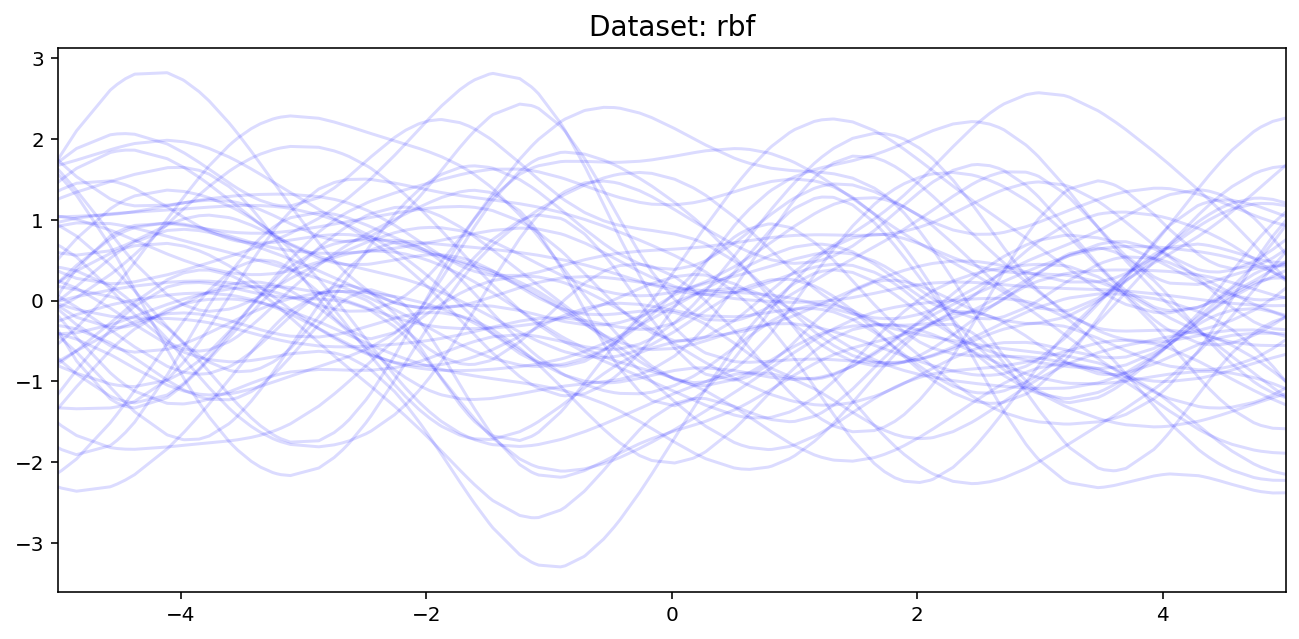

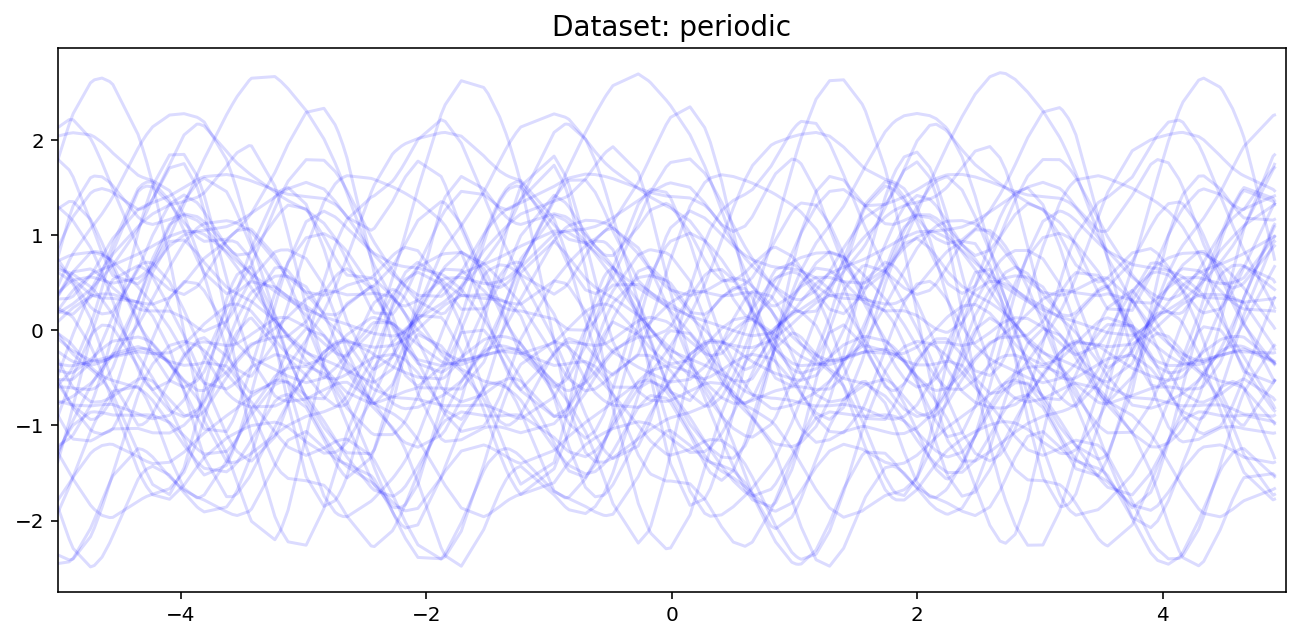

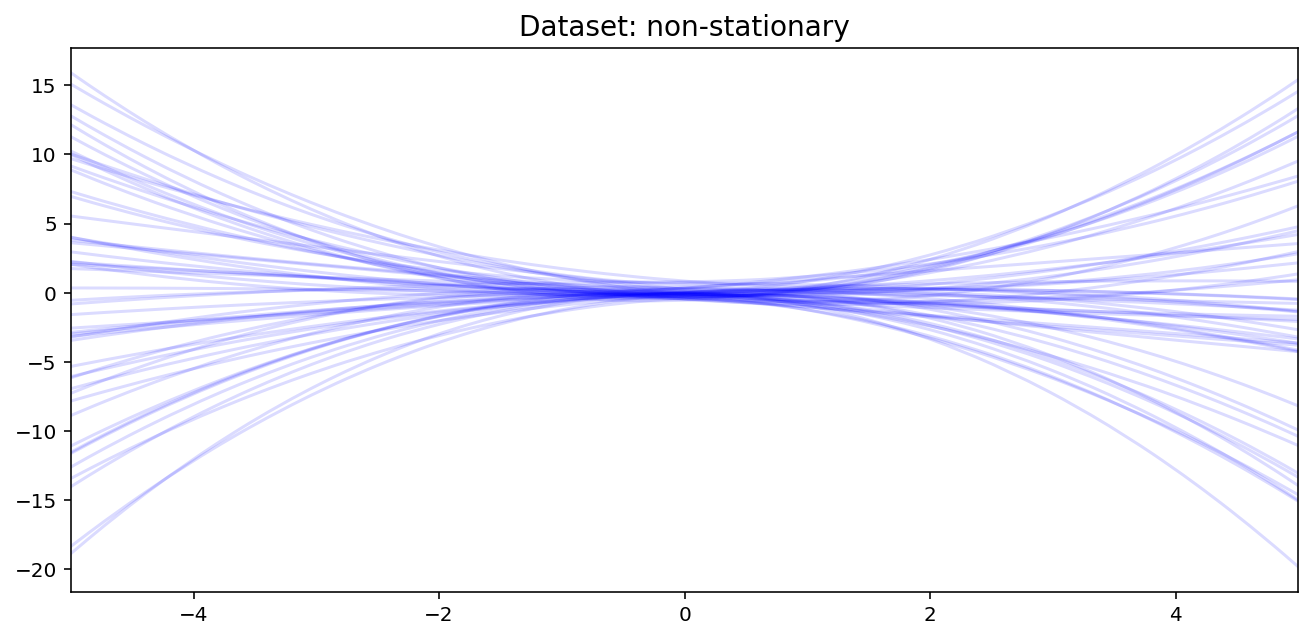

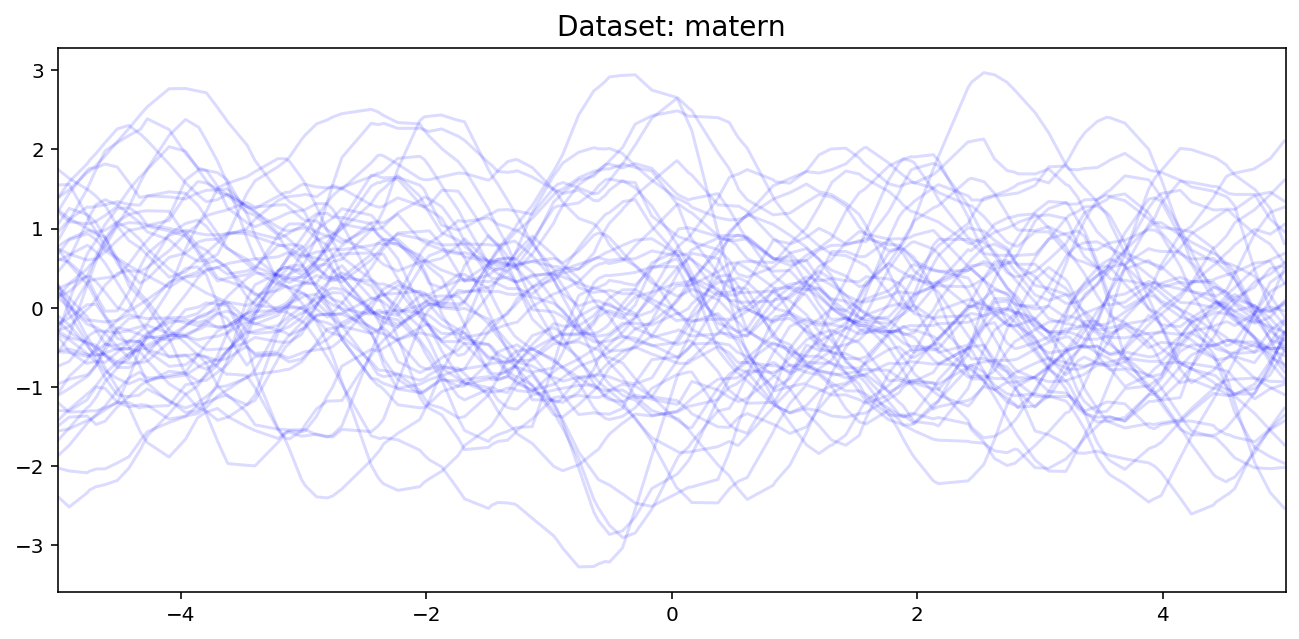

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. See the docstrings of `NeuralProcess` for more details.

Plot of CNP / NP / ANP, note that all the yellow modules on the right corresponds to the yellow module on the left `*`. $\oplus$ represents a commutative operation (called `aggregator` in the code), typically a `mean` operation.

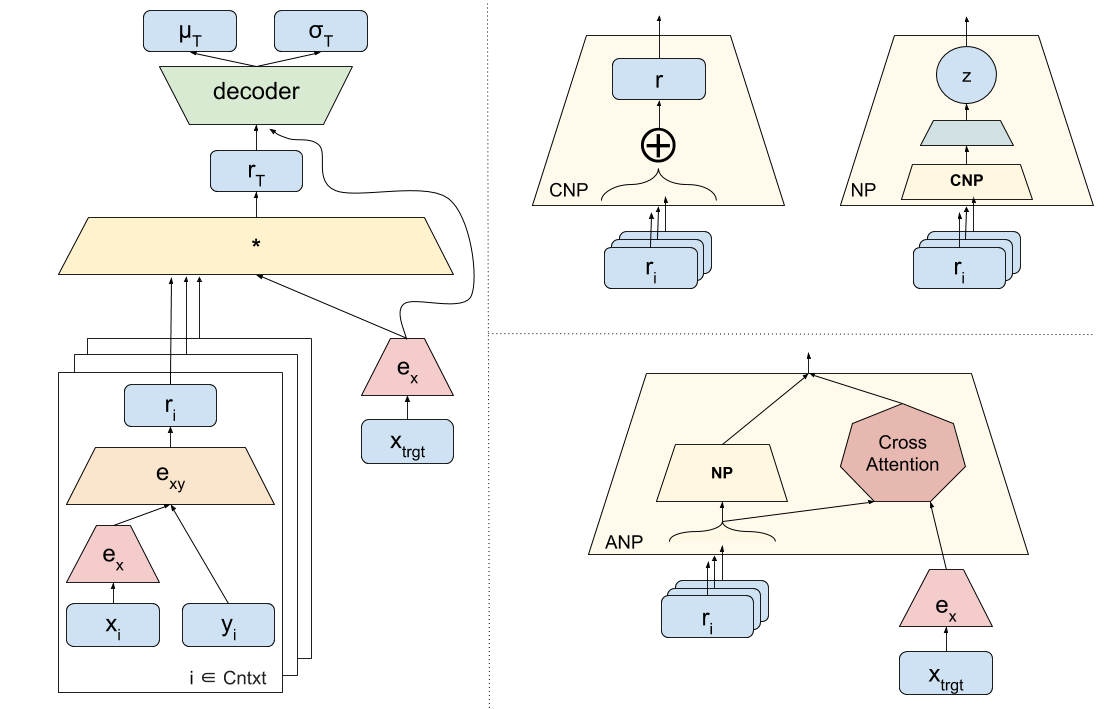

In [30]:
from IPython.display import Image
Image(filename='imgs/general_neural_process.png')

 Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension of hidden representation.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well (less parameter sharing)
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `merge_flat_input(MLP, is_sum_merge=False)` : learn representation with MLP. `merge_flat_input` concatenates (or sums) X and Y inputs.
    - `SelfAttentionBlock` : self attention mechanisms (as [Attentive Neural Process]). For more parameters (attention type, number of layers ...) refer to its docstrings.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `add_flat_input(MLP)` : predict with MLP.
    - `SelfAttentionBlock` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process], but in [image transformer][im transf]). 
- `aggregator` : Agregreator function which maps $\{r_i\} \to r$. To use a cross attention aggregation, use `AttentiveNeuralProcess` instead of `NeuralProcess`.
- `get_cntxt_trgt` :  Function that split the input into context and target points. Note: context points should be a subset of target ones.
- `PredicitiveDistribution` : Predictive distribution, e.g. `Normal`, `Laplace`, ....


**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 
    

**Extensions**

- For Neural Process, see the [Tutorial 2 - Neural Process] notebook.
- For Attentive Neural Process, see the [Tutorial 3 - Attentive Neural Process] notebook.
- Bayesian Hyperparameter Optimization is easy to run as the library is a wrapper around sklearn. To do so use `BayesSearchCV` from [skopt](https://scikit-optimize.github.io) which is in *requirements.txt* ([example](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html))

[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [14]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # share X encoding (not done in the paper) 
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=True),  # sum the encoded X and Y 
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=True),  # sum the encoded X and Y 
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, # Gaussian predictive distribution
                         encoded_path="deterministic") # use CNP

In [15]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [16]:
from utils.helpers import count_parameters

In [17]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 98498


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 0.5979520100355148


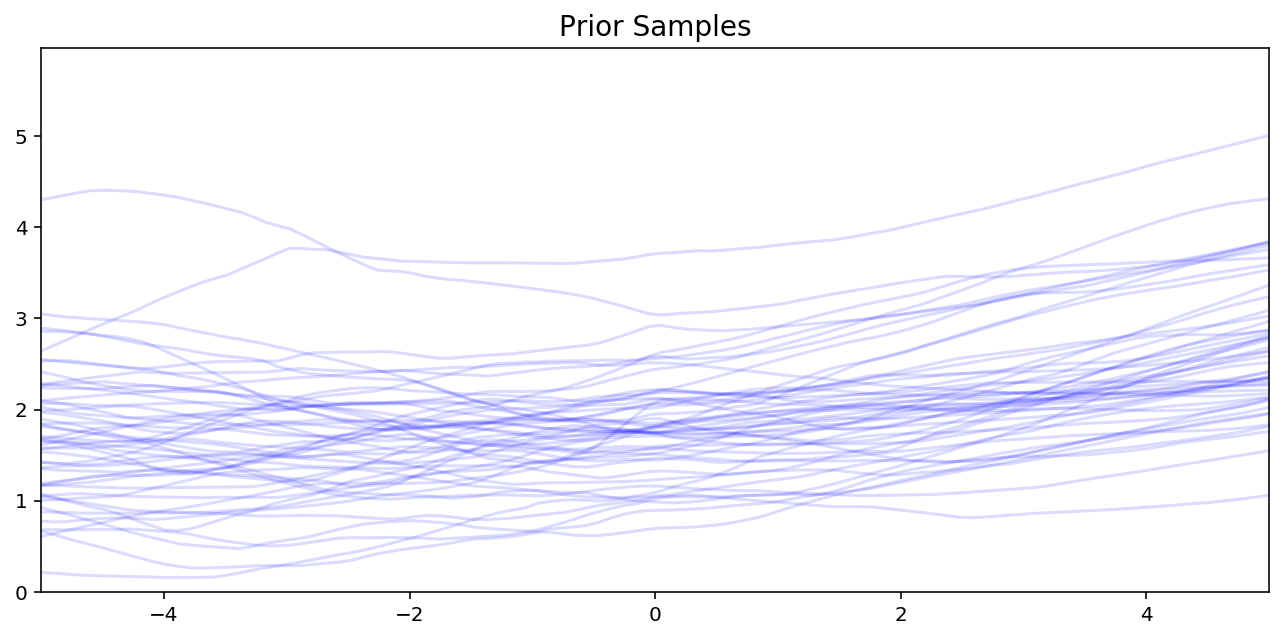

In [18]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

Training is handled by [skorch](https://github.com/skorch-dev/skorch), which is a sklearn-style wrapper around pytorch. The framework is slightly modified to enable semi-supervised learning. Refer to the docs (and `skssl.training`) for more details.

**Highltights**
- sklearn-style wrapper around pytorch. this is especially handy for downstream tasks to make a pipeline which does a task after being represented (i.e. transformed in sklearn jargon) by a CNP.
- many nice callbacks (including best model checkpoint used below)
- you can interrupt training and run again a cell: it will start where it last stoped


In [19]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [20]:
N_EPOCHS = 50 # 30 is enough
BATCH_SIZE = 64
is_RETRAIN = False # if false load precomputed

In [21]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))

    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      125.3280     +  14.4010


      2       88.6531     +  13.2689


      3       67.0891     +  15.5020


      4       54.7879     +  15.4834


      5       42.7118     +  15.2564


      6       33.6665     +  15.5070


      7       26.4460     +  15.5428


      8       18.6647     +  15.6463


      9       13.6598     +  12.3482


     10        9.7734     +  13.1967


     11        5.6632     +  16.1293


     12       -1.0006     +  15.9152


     13       -0.4877        16.3135


     14       -4.1128     +  16.3551


     15       -8.9130     +  18.0307


     16      -12.4052     +  17.7912


     17      -16.9473     +  18.8562


     18      -15.8098        18.9088


     19      -17.8220     +  18.7092


     20      -18.9665     +  18.6467


     21      -19.4407     +  18.2611


     22      -20.1111     +  18.0473


     23      -21.5646     +  18.5546


     24      -24.5271     +  19.3447


     25      -28.2064     +  18.2879


     26      -27.5866        18.9194


     27      -31.0734     +  19.0889


     28      -26.3335        18.7516


     29      -29.7688        18.9701


     30      -33.3060     +  17.8667


     31      -30.7582        18.8042


     32      -32.8701        18.8630


     33      -31.3301        17.7513


     34      -33.4305     +  19.6174


     35      -37.4146     +  23.3216


     36      -34.9436        24.8451


     37      -38.0062     +  24.5185


     38      -36.9385        24.3420


     39      -38.7924     +  24.7249


     40      -42.2548     +  24.4467


     41      -38.0609        24.1395


     42      -38.2723        24.1666


     43      -41.2019        24.8833


     44      -42.8699     +  24.4915


     45      -39.6897        24.3140


     46      -44.5665     +  23.8548


     47      -42.0061        24.0577


     48      -40.2320        24.1513


     49      -43.0519        18.4506


     50      -44.5957     +  18.8006
Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      135.2203     +  18.8016


      2      133.1930     +  18.4444


      3      132.8828     +  18.9073


      4      123.4289     +  18.5966


      5       85.5756     +  18.2383


      6       75.5376     +  19.5515


      7       71.7055     +  18.9730


      8       65.5608     +  18.7537


      9       60.2905     +  19.0715


     10       55.0306     +  18.1528


     11       46.9567     +  19.1195


     12       39.6048     +  18.5196


     13       34.2079     +  17.6141


     14       29.8303     +  18.2918


     15       25.5179     +  19.0047


     16       23.3211     +  18.4705


     17       19.1343     +  17.9636


     18       19.8581        18.8675


     19       17.3127     +  18.7161


     20       12.3765     +  18.4686


     21       11.3530     +  17.9498


     22        7.4761     +  17.6212


     23        7.5354        19.2857


     24        3.2647     +  18.5249


     25       -0.1569     +  17.9139


     26       -0.5213     +  18.6868


     27       -2.3221     +  17.7038


     28       -1.4257        18.8026


     29       -3.3405     +  19.3595


     30       -8.0148     +  18.8578


     31       -7.7851        18.1449


     32       -8.8620     +  18.2463


     33       -7.0114        18.9043


     34      -10.3512     +  19.1773


     35      -14.2158     +  18.7831


     36      -16.8985     +  18.7374


     37      -15.6168        19.0083


     38      -18.4363     +  18.6110


     39      -17.9110        18.7700


     40      -20.6162     +  18.8211


     41      -18.7094        19.0080


     42      -19.8062        22.3456


     43      -24.3750     +  22.6026


     44      -22.1499        22.6322


     45      -24.4012     +  22.5410


     46      -27.4897     +  22.1396


     47      -24.1036        22.4046


     48      -21.1549        22.9779


     49      -25.8109        23.0862


     50      -26.0148        22.8867
Re-initializing optimizer because the following parameters were re-set: .

--- Training non-stationary ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1     1256.3867     +  22.8345


      2       88.7539     +  23.1495


      3       60.1673     +  22.4357


      4       38.2070     +  22.6832


      5       17.7973     +  22.7596


      6        5.3396     +  23.0629


      7       -6.4096     +  22.4487


      8      -17.3443     +  22.7589


      9      -24.9475     +  23.0051


     10      -32.7924     +  22.7870


     11      -41.4946     +  22.7912


     12      -47.0207     +  22.8059


     13      -50.0392     +  22.5367


     14      -52.3974     +  22.4004


     15      -55.4356     +  22.4372


     16      -61.0559     +  22.0289


     17      -57.1023        22.8306


     18      -63.3408     +  23.0201


     19      -63.4821     +  22.7461


     20      -65.2302     +  22.7906


     21      -62.8632        23.2052


     22      -66.2049     +  22.7896


     23      -67.4404     +  23.1747


     24      -72.9324     +  22.7161


     25      -76.7167     +  22.1072


     26      -79.0403     +  22.7345


     27      -77.3843        22.7024


     28      -72.6189        22.7325


     29      -76.0962        22.4014


     30      -78.5006        23.0746


     31      -72.2457        22.6405


     32      -75.0307        22.8043


     33      -73.2892        23.2319


     34      -81.5537     +  19.3447


     35      -77.1541        18.6051


     36      -82.7323     +  19.4952


     37      -82.5622        17.7278


     38      -84.8403     +  17.4525


     39      -86.4895     +  17.6215


     40      -87.3116     +  18.1141


     41      -80.8115        18.8023


     42      -78.7104        20.9853


     43      -85.1982        21.7773


     44      -87.5218     +  21.9829


     45      -83.0691        22.2050


     46      -86.9703        21.5146


     47      -84.4725        21.8654


     48      -77.7409        22.1325


     49      -88.3851     +  21.3333


     50      -89.4963     +  22.2593
Re-initializing optimizer because the following parameters were re-set: .

--- Training matern ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      131.4815     +  22.4513


      2      106.4849     +  21.8043


      3       94.2830     +  22.3223


      4       86.9445     +  22.2474


      5       79.5903     +  21.3019


      6       73.8423     +  21.8169


      7       70.1847     +  22.3786


      8       65.4727     +  21.7467


      9       61.7840     +  20.9774


     10       60.9782     +  21.6955


     11       58.9036     +  21.7003


     12       54.3914     +  21.1627


     13       53.7936     +  22.2336


     14       51.9112     +  21.9875


     15       49.4135     +  19.1191


     16       46.9845     +  18.6267


     17       43.9216     +  18.8200


     18       44.3873        18.2795


     19       43.2703     +  18.1867


     20       41.7326     +  19.1016


     21       41.3805     +  17.9513


     22       40.3324     +  18.3182


     23       40.0459     +  17.6236


     24       37.8551     +  18.3777


     25       35.3548     +  18.7022


     26       35.5282        17.9510


     27       33.9599     +  18.7679


     28       36.5466        19.1096


     29       33.9543     +  18.8014


     30       31.9452     +  19.2095


     31       31.4516     +  19.3405


     32       32.0144        18.8082


     33       31.2573     +  18.7146


     34       30.7582     +  19.1261


     35       28.2285     +  18.7931


     36       28.9601        18.9727


     37       26.5722     +  19.0668


     38       28.0879        18.9754


     39       26.4224     +  18.6171


     40       24.2622     +  19.1234


     41       27.8881        19.2033


     42       29.1144        17.7650


     43       25.4923        19.2158


     44       25.4033        19.1249


     45       26.3517        18.6116


     46       22.4336     +  17.9466


     47       24.0843        18.5047


     48       27.4165        18.7008


     49       23.3231        17.9602


     50       24.2285        18.8350
Re-initializing optimizer because the following parameters were re-set: .


# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn a kernel functions from the data, if they are effective teh trained prior should thus be very similar to the the samples the datasets previously seen.

In [22]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 2.7107292139530186
std: 1.6040621624886988
std: 1.944236941635608
std: 3.9903715300560005


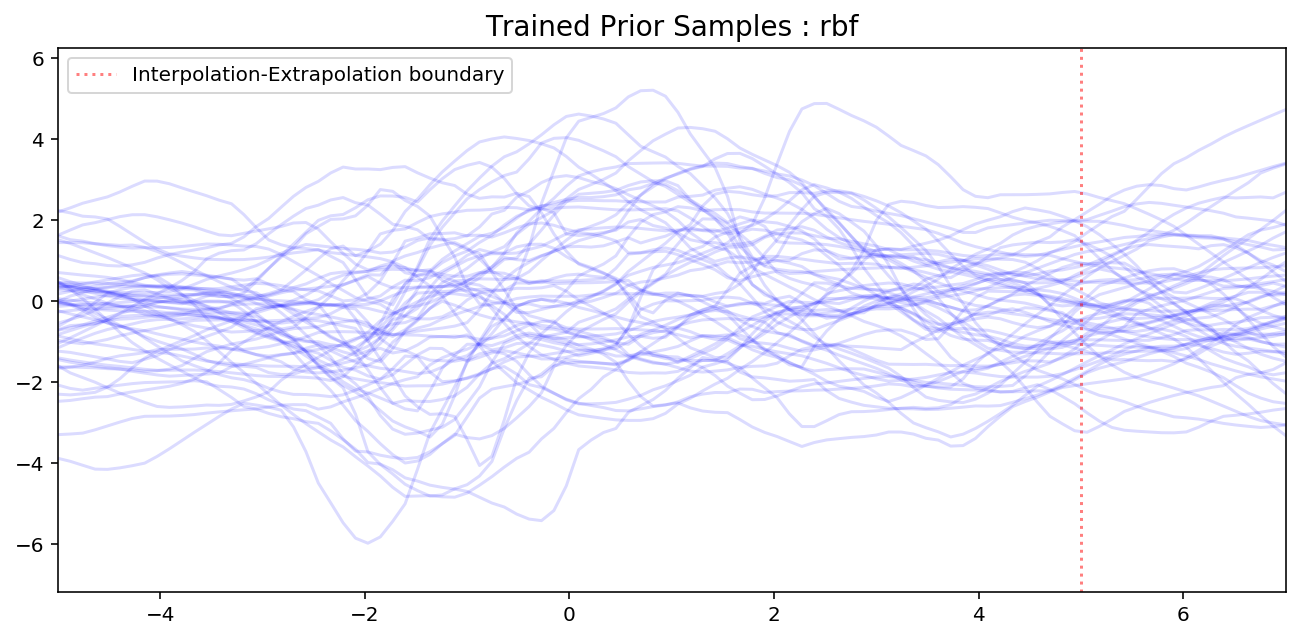

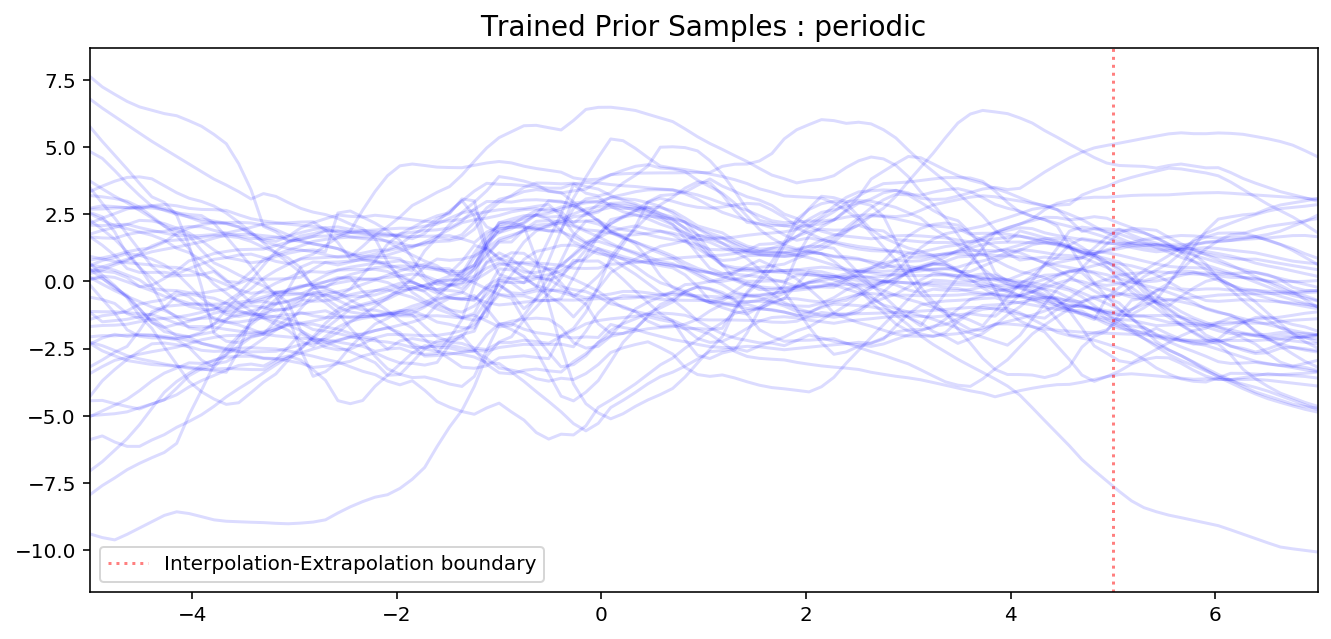

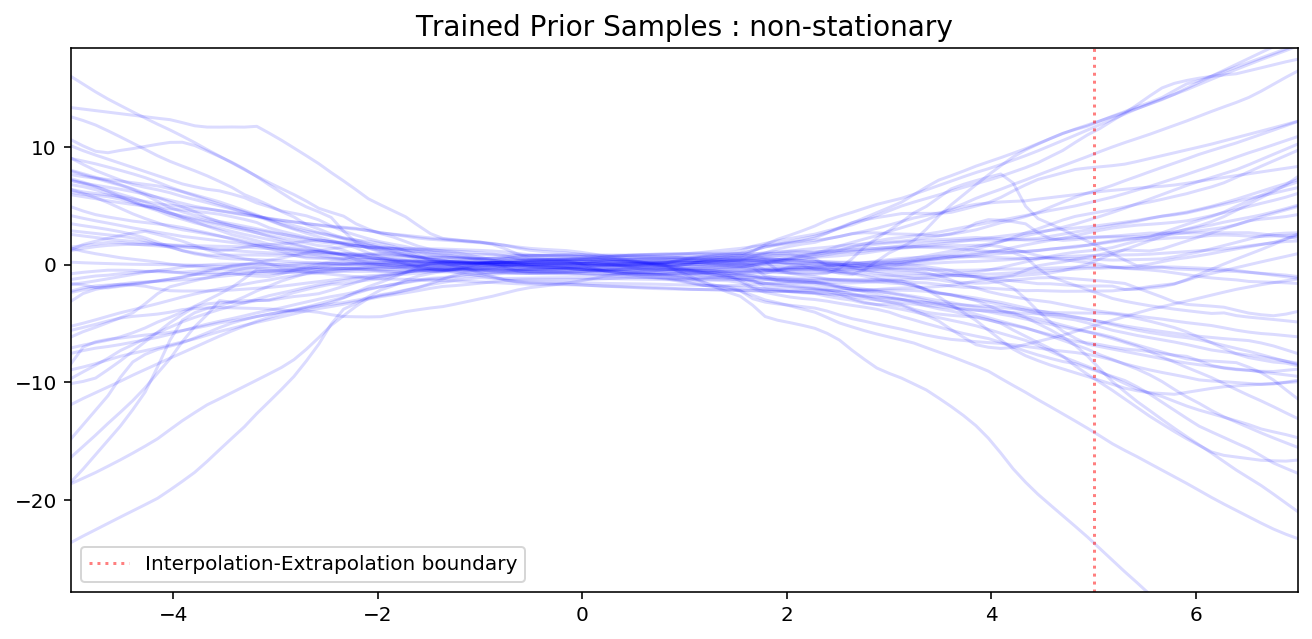

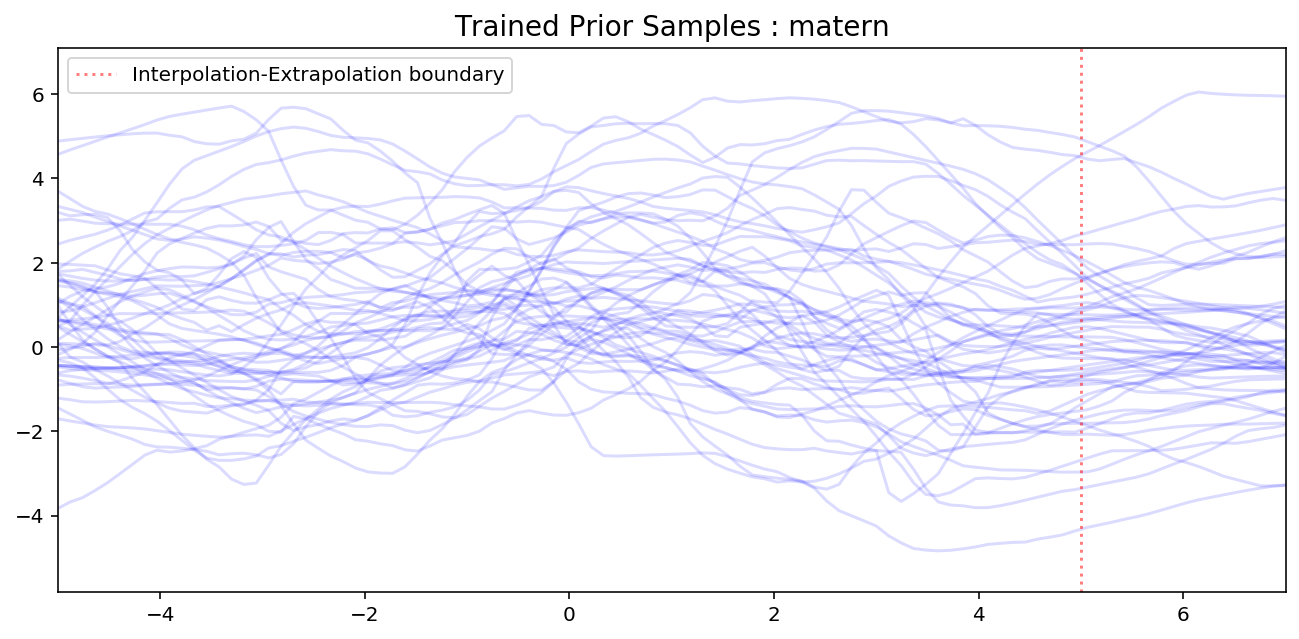

In [23]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

std: 0.9181654453277588
std: 0.7287637591362
std: 0.43981948494911194
std: 0.9957165122032166


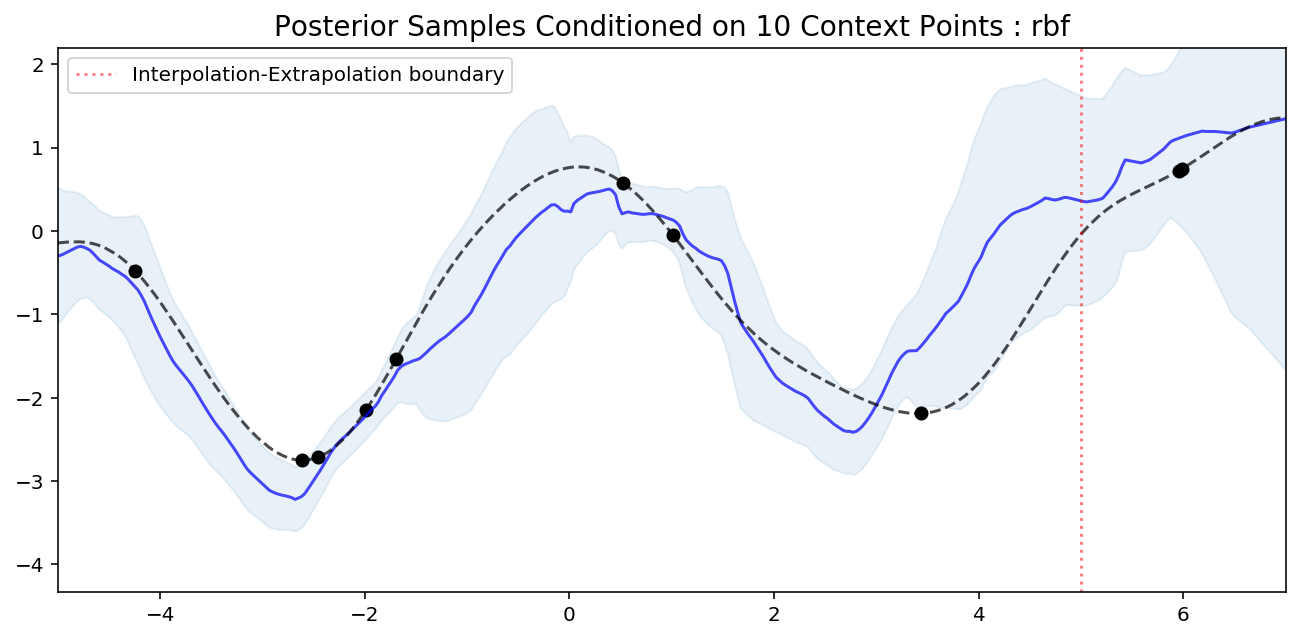

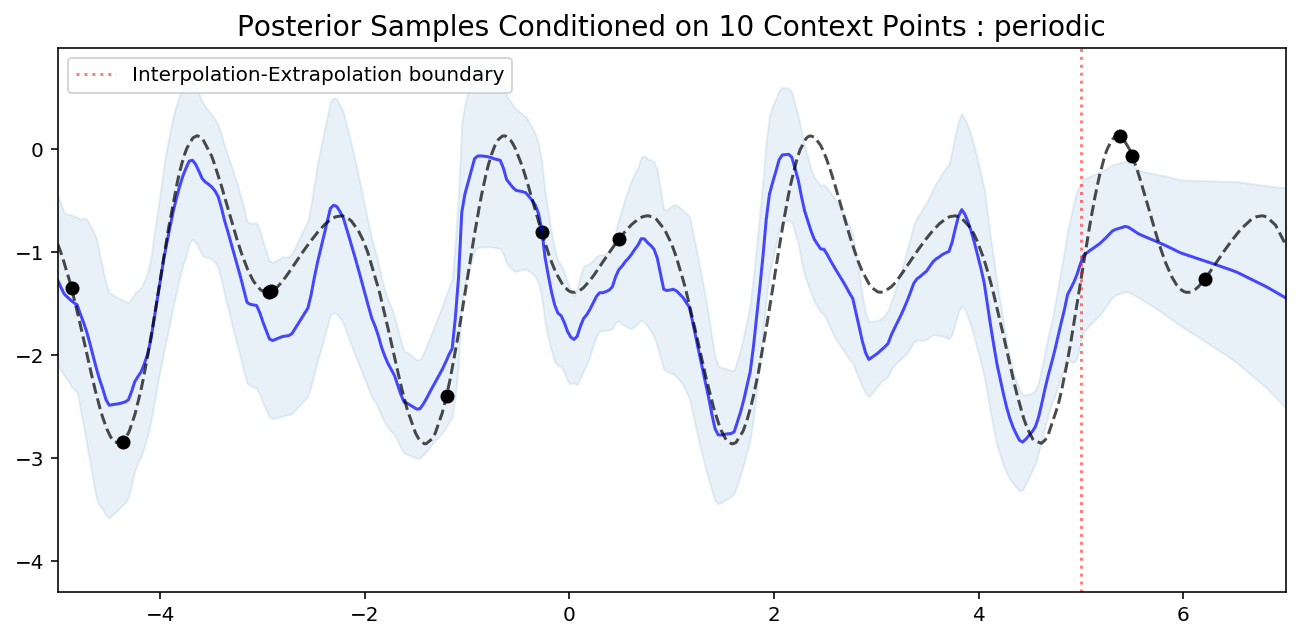

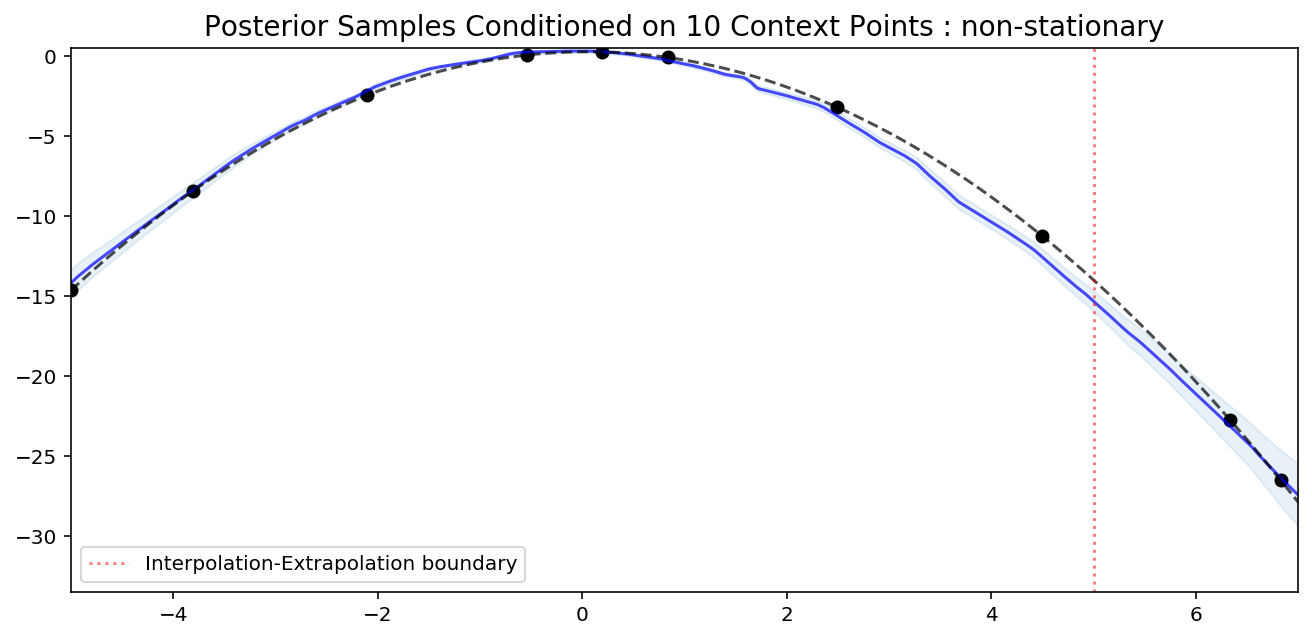

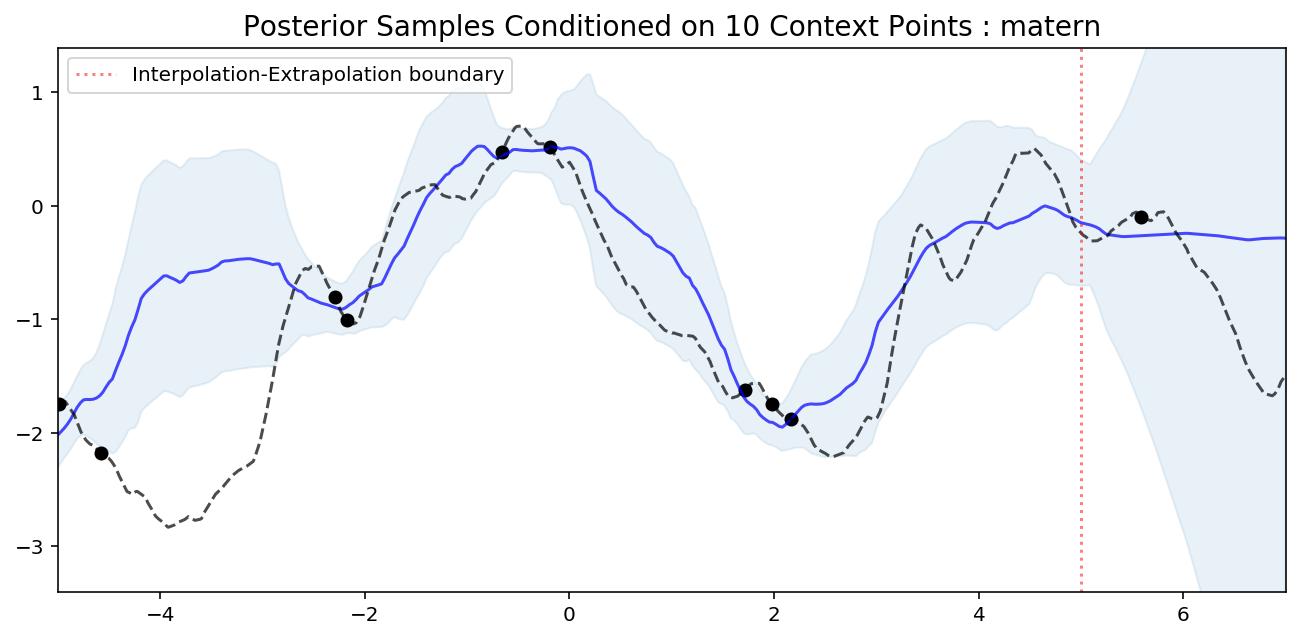

In [24]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

To have a better understanding of uncertainty let's look at only 2 context points:

std: 1.2956976890563965
std: 0.6526877284049988
std: 0.9773672223091125
std: 1.293668270111084


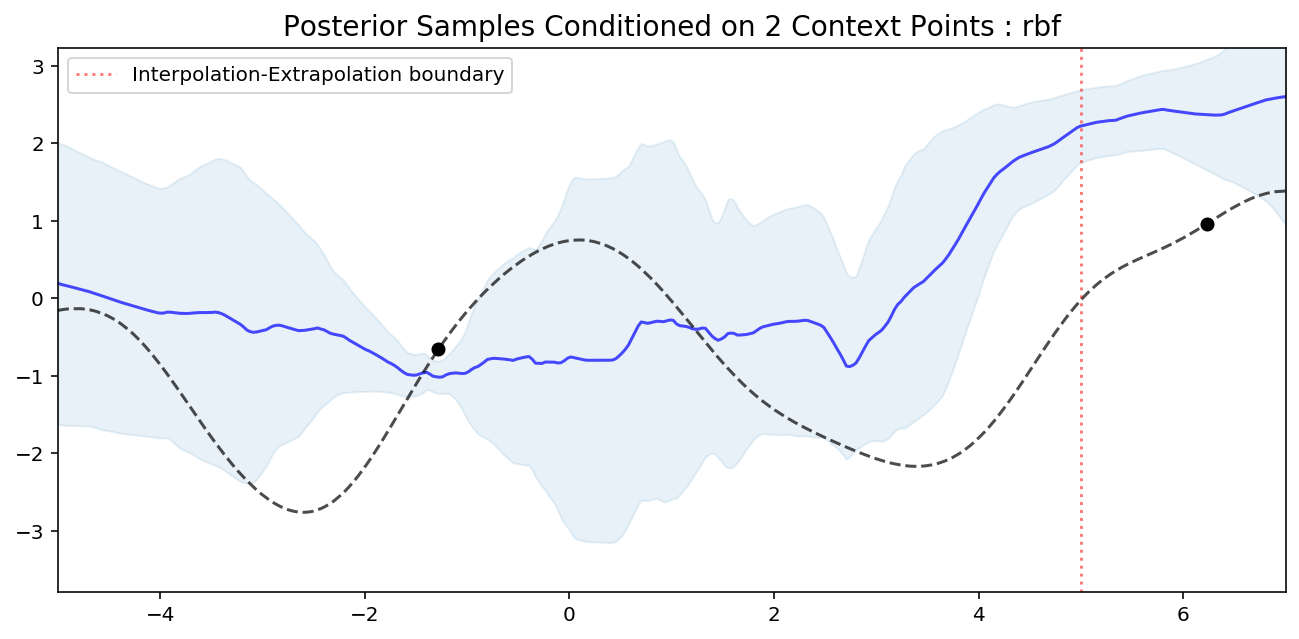

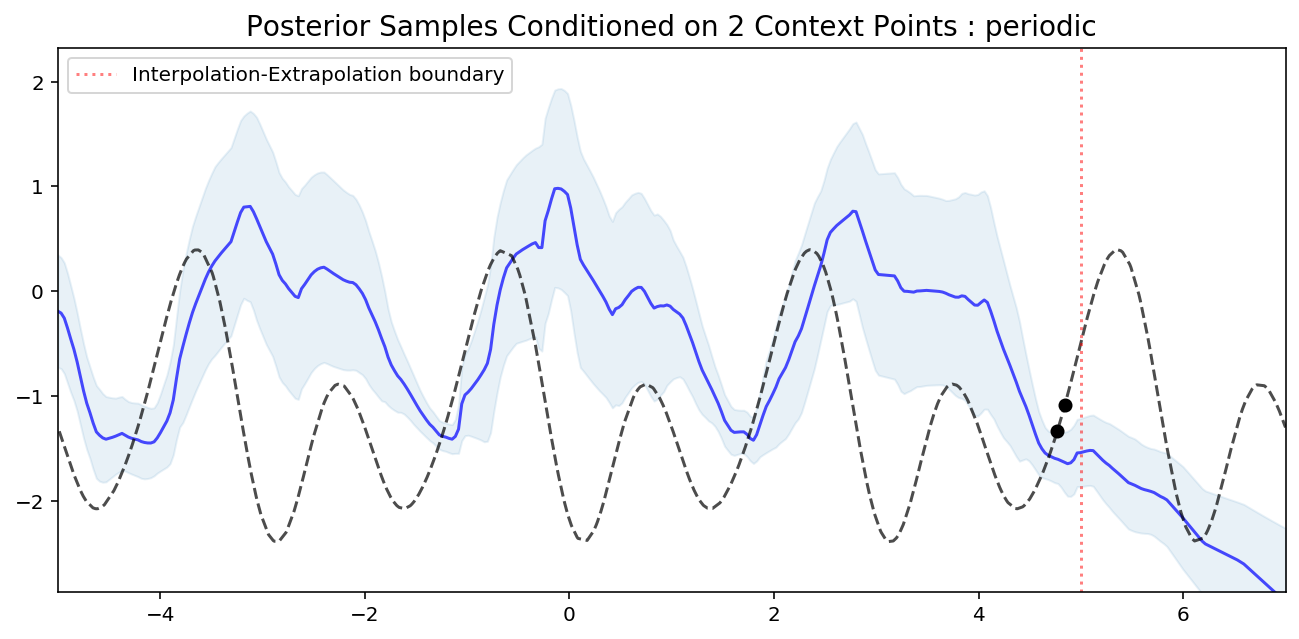

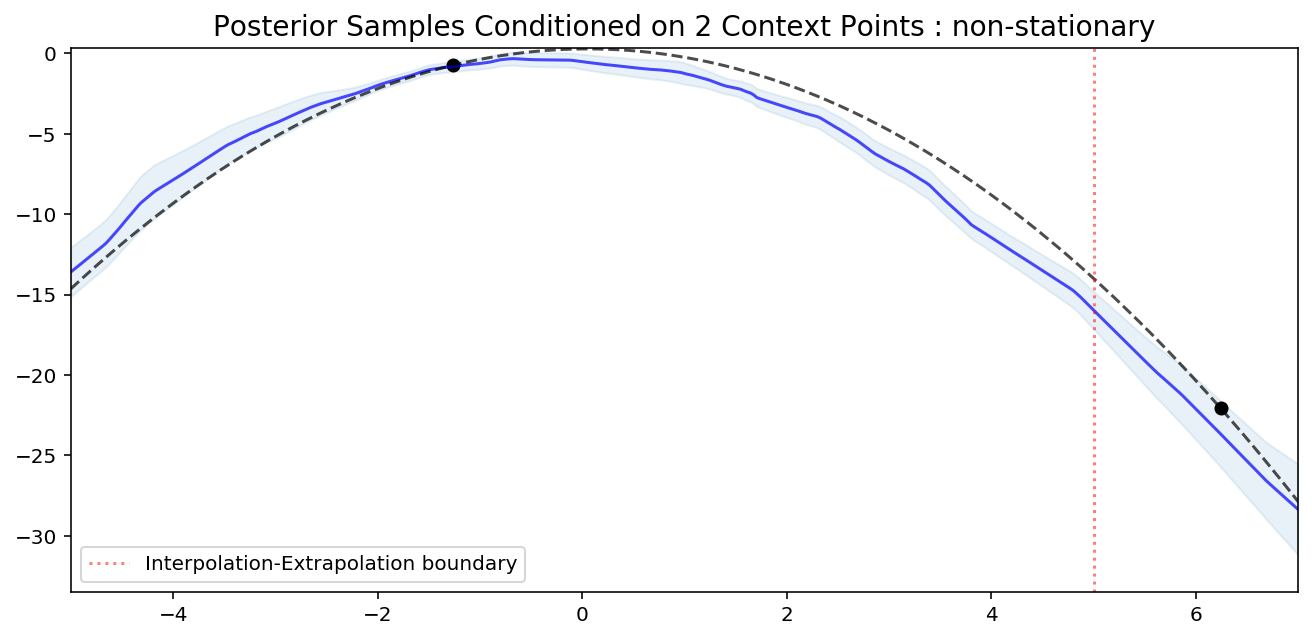

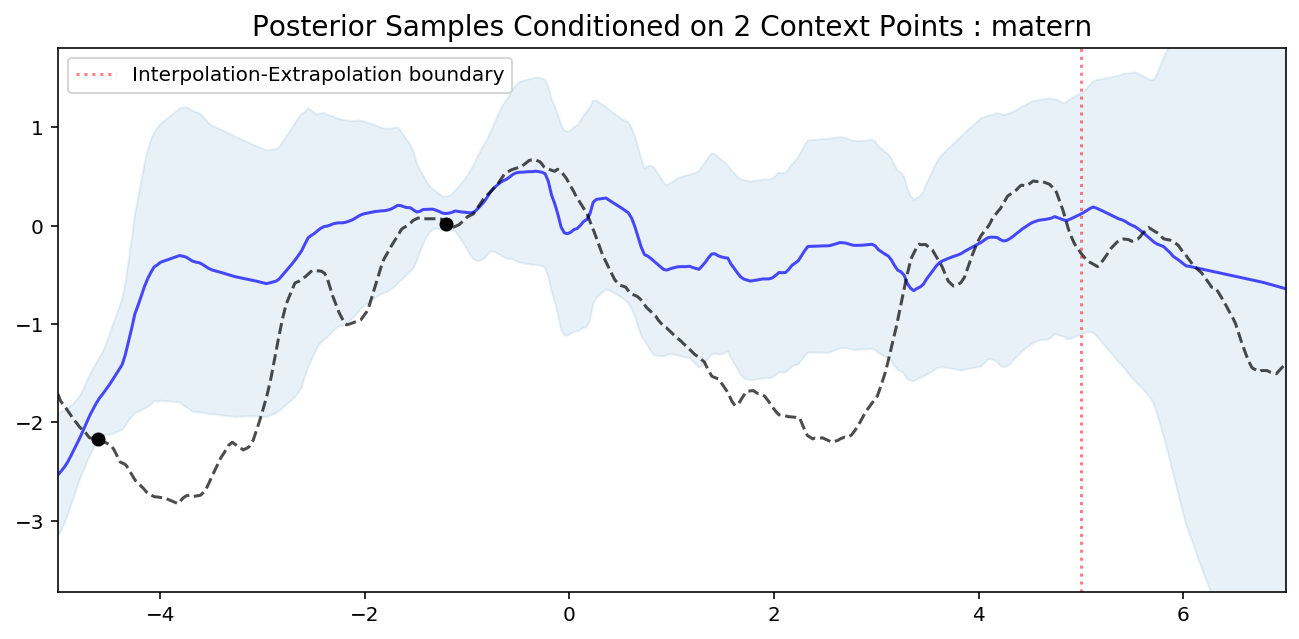

In [25]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

What about 20:

std: 0.39737364649772644
std: 0.3311154246330261
std: 0.4749673902988434
std: 0.7873461246490479


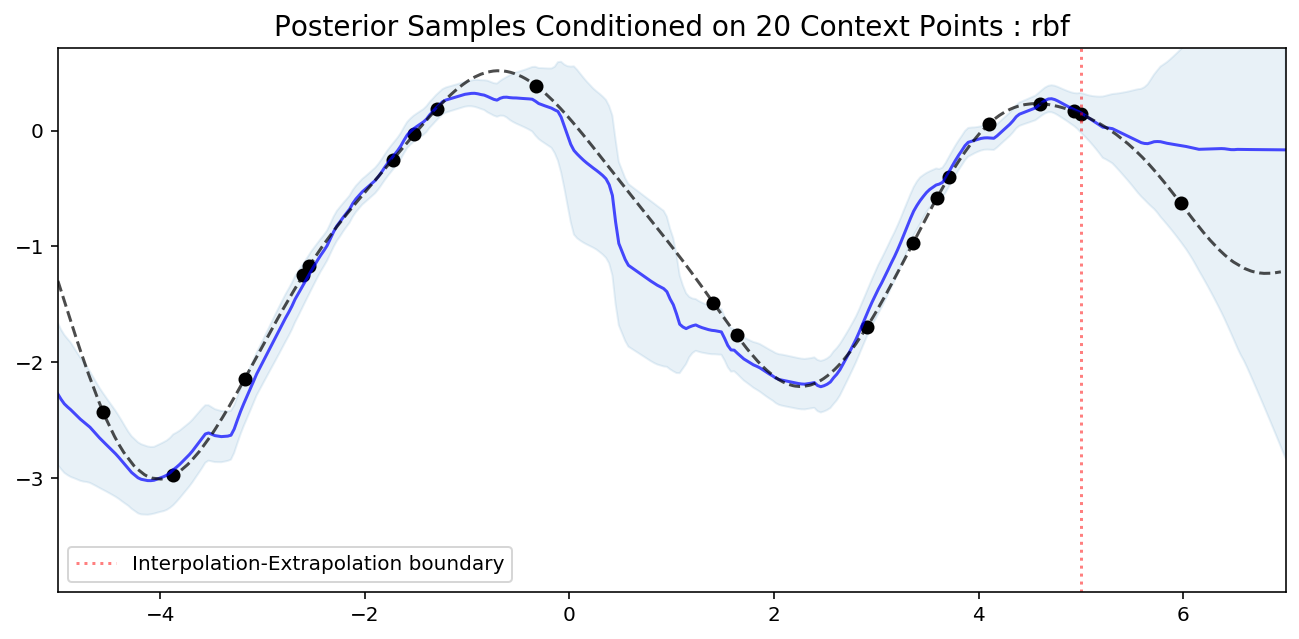

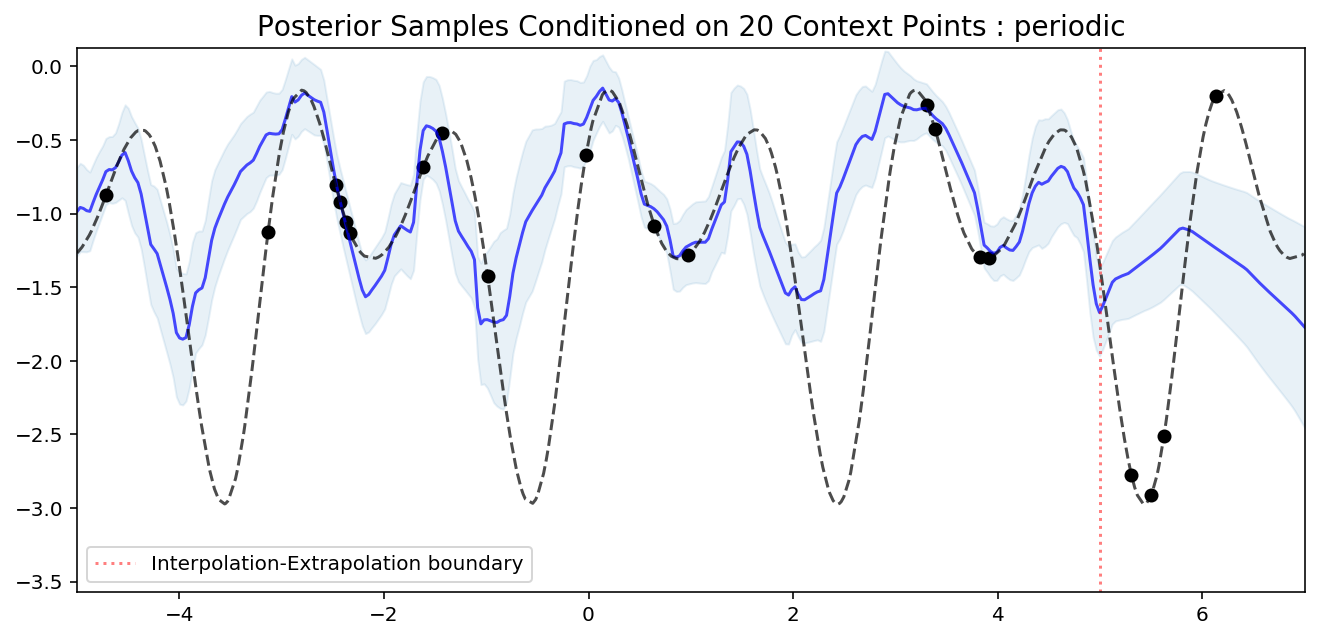

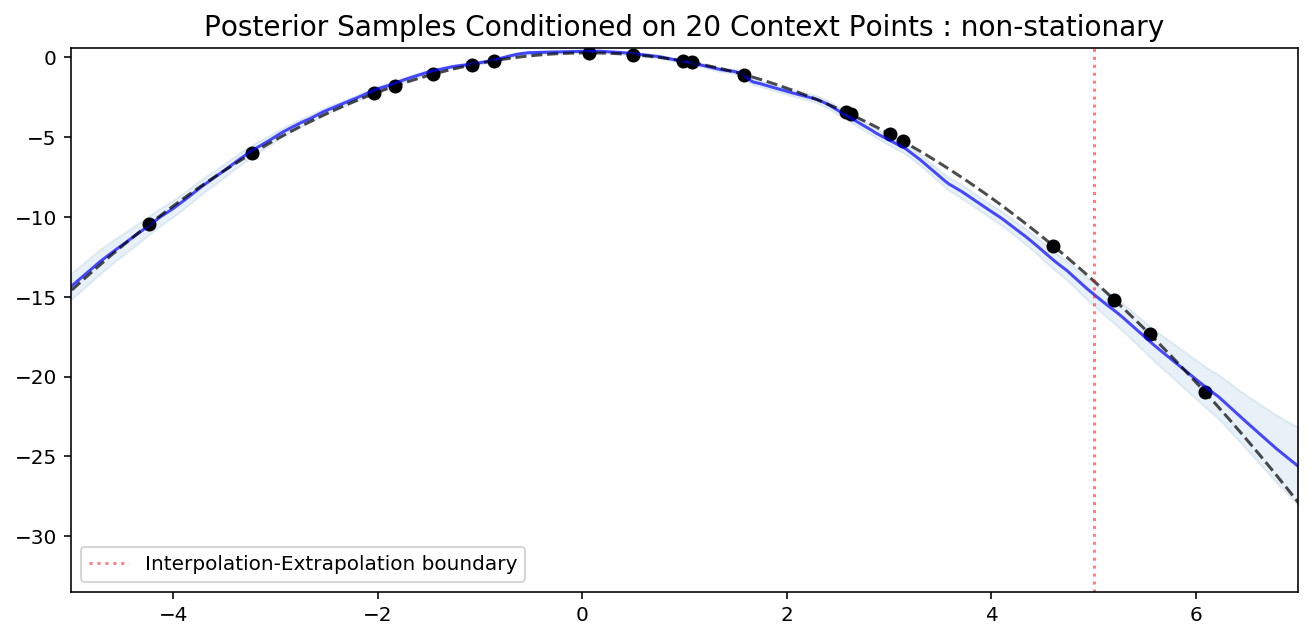

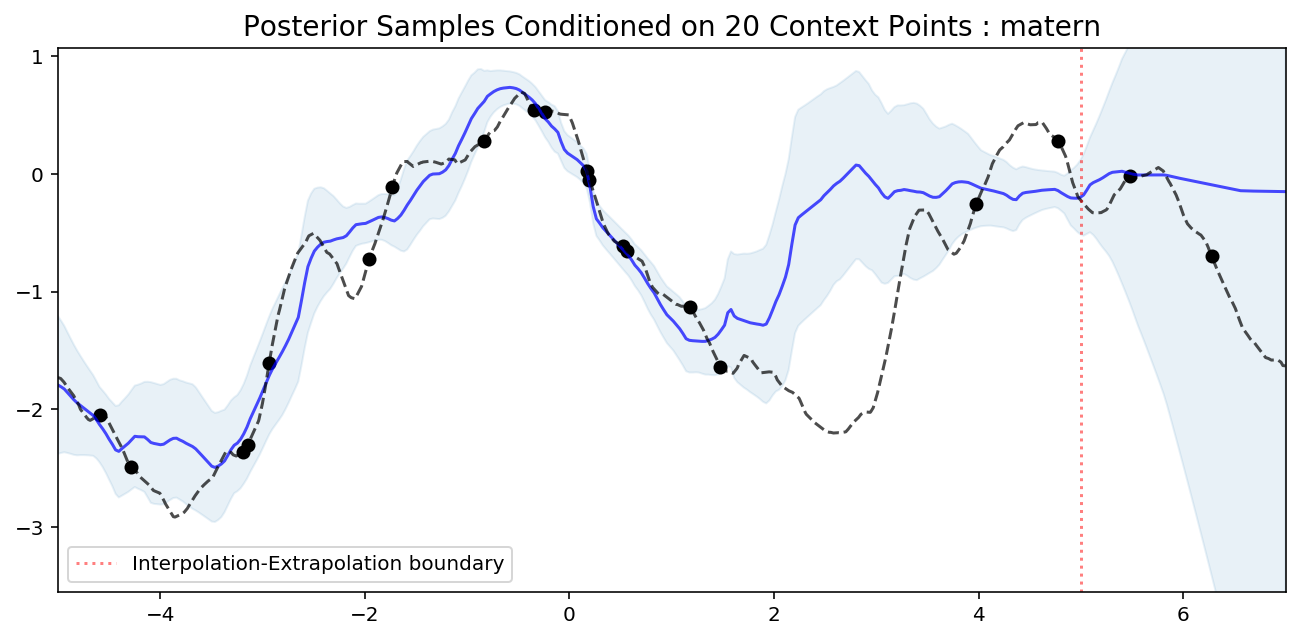

In [26]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are not too bad.

**Good**:
- The standard devation does not collapse to the minimum value it can output (i.e. 0.1). 
- It is also relatively uncertain far from context points. This is even more true when extrapolating

**Bad**:
- it often underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).
- periodicity pattern is not really periodic, which becomes clear when extrapolating